In [1]:
!git clone https://github.com/ao9000/sc4002_g24

Cloning into 'sc4002_g24'...
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')


Found GPU at: /device:GPU:0


In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pickle

In [6]:
%pip  install torch datasets nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00


In [5]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
import pickle
import numpy as np
from torch.utils.data import Dataset, DataLoader

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=ff_dim,
                dropout=dropout
            ),
            num_layers=num_layers
        )

    def forward(self, x, mask=None):
        # x shape: (seq_len, batch_size, embed_dim)
        return self.transformer_encoder(x, src_key_padding_mask=mask)

class TextDataset(Dataset):
    def __init__(self, texts, labels, embeddings_matrix, word_to_idx, max_len):
        self.texts = texts
        self.labels = labels
        self.embeddings_matrix = embeddings_matrix
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Convert text to embedding sequence
        word_indices = [self.word_to_idx.get(word, 0) for word in text.split()[:self.max_len]]
        embeddings = self.embeddings_matrix[word_indices]

        # Pad sequence if necessary
        if len(embeddings) < self.max_len:
            padding = np.zeros((self.max_len - len(embeddings), self.embeddings_matrix.shape[1]))
            embeddings = np.vstack([embeddings, padding])

        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(self.labels[idx])

def load_embeddings(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    # Handle different possible formats of the pickle file
    if isinstance(data, tuple):
        # If the data is a tuple, assume it contains (embedding_matrix, word_to_idx)
        embedding_matrix, word_to_idx = data
    elif isinstance(data, np.ndarray):
        # If the data is just the embedding matrix, create a simple word_to_idx
        embedding_matrix = data
        word_to_idx = {str(i): i for i in range(len(embedding_matrix))}
    else:
        # If the data is a dictionary
        word_to_idx = {word: idx for idx, word in enumerate(data.keys())}
        embedding_matrix = np.array(list(data.values()))

    return embedding_matrix, word_to_idx

def train_transformer(train_texts, train_labels, embeddings_path,
                     max_len=128, batch_size=32, num_epochs=5):
    # Load pre-trained embeddings
    embedding_matrix, word_to_idx = load_embeddings(embeddings_path)
    embed_dim = embedding_matrix.shape[1]

    # Create dataset and dataloader
    dataset = TextDataset(train_texts, train_labels, embedding_matrix, word_to_idx, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = TransformerEncoder(
        embed_dim=embed_dim,
        num_heads=8,
        num_layers=6,
        ff_dim=embed_dim * 4
    )

    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_embeddings, batch_labels in dataloader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_embeddings.permute(1, 0, 2))  # Transform to (seq_len, batch, features)
            outputs = outputs.mean(dim=0)  # Average pooling over sequence length

            # Calculate loss
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    return model



# Example usage
if __name__ == "__main__":
    # Sample data
    texts = ["sample text one", "sample text two"]
    labels = [0, 1]
    embeddings_path = "/content/drive/MyDrive/Colab Notebooks/sc4002_g24/embedding_matrix_200d.pkl"
    model = train_transformer(texts, labels, embeddings_path)
    # embeddings_path = "path/to/embeddings.pkl"

    # model = train_transformer(texts, labels, embeddings_path)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5, Average Loss: 5.9957
Epoch 2/5, Average Loss: 1.6747
Epoch 3/5, Average Loss: 0.8888
Epoch 4/5, Average Loss: 1.3668
Epoch 5/5, Average Loss: 0.7707


In [1]:
import torch
import torch.nn as nn
import pickle
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim, num_classes, dropout=0.1):
        super().__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=ff_dim,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        # Add classification head
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, mask=None):
        # x shape: (seq_len, batch_size, embed_dim)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)
        # Average pooling over sequence length
        x = x.mean(dim=0)  # (batch_size, embed_dim)
        # Classification layer
        return self.classifier(x)  # (batch_size, num_classes)

class TextDataset(Dataset):
    def __init__(self, texts, labels, embeddings_matrix, word_to_idx, max_len):
        self.texts = texts
        self.labels = labels
        self.embeddings_matrix = embeddings_matrix
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Convert text to embedding sequence
        word_indices = [self.word_to_idx.get(word, 0) for word in text.split()[:self.max_len]]
        embeddings = self.embeddings_matrix[word_indices]

        # Pad sequence if necessary
        if len(embeddings) < self.max_len:
            padding = np.zeros((self.max_len - len(embeddings), self.embeddings_matrix.shape[1]))
            embeddings = np.vstack([embeddings, padding])

        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(self.labels[idx])

def load_embeddings(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    if isinstance(data, tuple):
        embedding_matrix, word_to_idx = data
    elif isinstance(data, np.ndarray):
        embedding_matrix = data
        word_to_idx = {str(i): i for i in range(len(embedding_matrix))}
    else:
        word_to_idx = {word: idx for idx, word in enumerate(data.keys())}
        embedding_matrix = np.array(list(data.values()))

    return embedding_matrix, word_to_idx

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_embeddings, batch_labels in dataloader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_embeddings.permute(1, 0, 2))
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def train_transformer(train_texts, train_labels, val_texts=None, val_labels=None,
                     embeddings_path=None, max_len=128, batch_size=32, num_epochs=5):
    # Load pre-trained embeddings
    embedding_matrix, word_to_idx = load_embeddings(embeddings_path)
    embed_dim = embedding_matrix.shape[1]

    # Get number of unique classes
    num_classes = len(set(train_labels))

    # Create train dataset and dataloader
    train_dataset = TextDataset(train_texts, train_labels, embedding_matrix, word_to_idx, max_len)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create validation dataset and dataloader if validation data is provided
    if val_texts is not None and val_labels is not None:
        val_dataset = TextDataset(val_texts, val_labels, embedding_matrix, word_to_idx, max_len)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = TransformerEncoder(
        embed_dim=embed_dim,
        num_heads=8,
        num_layers=6,
        ff_dim=embed_dim * 4,
        num_classes=num_classes
    )

    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []

        for batch_embeddings, batch_labels in train_dataloader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_embeddings.permute(1, 0, 2))

            # Calculate loss
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Get predictions for accuracy calculation
            _, predicted = torch.max(outputs, 1)
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(batch_labels.cpu().numpy())

        # Calculate training metrics
        avg_loss = total_loss / len(train_dataloader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)

        # Calculate validation metrics
        if val_texts is not None and val_labels is not None:
            val_accuracy = evaluate(model, val_dataloader, device)

            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), 'best_model.pth')

            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {avg_loss:.4f}')
            print(f'  Train Accuracy: {train_accuracy:.4f}')
            print(f'  Validation Accuracy: {val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {avg_loss:.4f}')
            print(f'  Train Accuracy: {train_accuracy:.4f}')

    # Load best model if validation was used
    if val_texts is not None and val_labels is not None:
        model.load_state_dict(torch.load('best_model.pth'))
        print(f'\nBest Validation Accuracy: {best_val_accuracy:.4f}')

    return model

# Example usage
if __name__ == "__main__":
    # Sample data
    texts = ["sample text one", "sample text two", "sample text three"]
    labels = [0, 1, 0]

    # Split into train and validation sets
    val_texts = texts[-1:]
    val_labels = labels[-1:]
    train_texts = texts[:-1]
    train_labels = labels[:-1]

    embeddings_path = "/content/drive/MyDrive/Colab Notebooks/sc4002_g24/embedding_matrix_200d.pkl"

    model = train_transformer(
        train_texts=train_texts,
        train_labels=train_labels,
        val_texts=val_texts,
        val_labels=val_labels,
        embeddings_path=embeddings_path
    )

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/sc4002_g24/embedding_matrix_200d.pkl'

In [6]:
from datasets import load_dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [9]:
print(train_dataset[0])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


In [17]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split



model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])



from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Then specify this data_collator in your Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=64,  # Adjust based on GPU memory
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.365530,0.831144,0.835395,0.831144,0.830608
2,No log,0.428663,0.841463,0.843496,0.841463,0.841229
3,No log,0.449511,0.853659,0.854502,0.853659,0.853571
4,0.255300,0.537023,0.850844,0.850944,0.850844,0.850834
5,0.255300,0.654303,0.850844,0.850846,0.850844,0.850844


TrainOutput(global_step=670, training_loss=0.20775941734883321, metrics={'train_runtime': 306.4979, 'train_samples_per_second': 139.153, 'train_steps_per_second': 2.186, 'total_flos': 882786766824000.0, 'train_loss': 0.20775941734883321, 'epoch': 5.0})

Accuracy: 0.8555
Precision: 0.8556
Recall: 0.8555
F1-Score: 0.8555


Text(0.5, 1.0, 'Confusion Matrix')

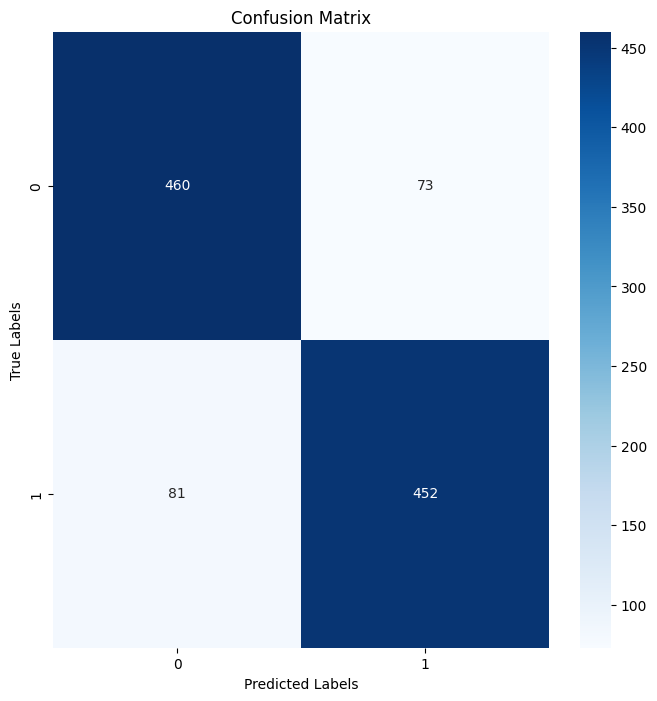

In [21]:

# Making predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')



In [20]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
import torch
from transformers import EarlyStoppingCallback

# 1. Improved data preprocessing
def preprocess_text(text):
    # Add your text cleaning steps here
    text = text.lower()
    text = text.strip()
    # Add more preprocessing steps as needed
    return text

def tokenize_and_encode(batch):
    # Preprocess text first
    texts = [preprocess_text(text) for text in batch["text"]]

    # Tokenize with truncation and padding
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# 2. Model initialization with better defaults
model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    problem_type="single_label_classification",
    attention_probs_dropout_prob=0.2,
    hidden_dropout_prob=0.2
)

# 3. Advanced training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    gradient_accumulation_steps=4,
    fp16=True,  # If using GPU
    logging_steps=50,
    group_by_length=True,  # Speeds up training by grouping similar lengths
    remove_unused_columns=True,
)

# 4. Enhanced metrics computation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Calculate metrics for each class
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average='weighted'
    )

    # Calculate confusion matrix metrics
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# 5. Custom data collator with dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',
    max_length=512,
    return_tensors="pt"
)

# 6. Initialize trainer with callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=1000000000,
            early_stopping_threshold=0.01
        )
    ],
)

# 7. Train with gradient clipping
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/p

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.839900,0.705171,0.500000,0.250000,0.500000,0.333333
200,0.889500,0.644477,0.661351,0.684557,0.661351,0.650360
300,0.659900,0.459749,0.796435,0.807935,0.796435,0.794517
400,0.520000,0.383178,0.840525,0.840760,0.840525,0.840498
500,0.427600,0.419379,0.827392,0.832809,0.827392,0.826687
600,0.412800,0.375598,0.848030,0.848108,0.848030,0.848021
700,0.356900,0.390389,0.848968,0.848999,0.848968,0.848965
800,0.316100,0.408171,0.847092,0.847534,0.847092,0.847043
900,0.307600,0.400506,0.855535,0.855855,0.855535,0.855502
1000,0.271600,0.415096,0.849906,0.850400,0.849906,0.849853


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1330, training_loss=0.43830124274232335, metrics={'train_runtime': 456.9713, 'train_samples_per_second': 186.664, 'train_steps_per_second': 2.91, 'total_flos': 1478457228208572.0, 'train_loss': 0.43830124274232335, 'epoch': 9.962546816479401})